Imports

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install pylatexenc
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully unin

In [ ]:
import qiskit
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from pylatexenc import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

IBM API connection

In [ ]:
service=QiskitRuntimeService(channel="ibm_quantum", token="279e836f9f3510ef1542253501b222d9d25a1701baf6167cee616c7708dbf3add9bc5d4a60a17a5bf39c76e57bae06b33b73833008cb9177c87137ed8bda49b2")

Circuit construction

In [ ]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
# Add a Hadamard gate to qubit 0
qc.h(0)
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

Printing circuit

In [ ]:
print(qc)

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


QMAB Project

     ┌───┐┌─────────┐
q_0: ┤ H ├┤ Rx(π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ Rx(π/4) ├
     ├───┤├─────────┤
q_2: ┤ H ├┤ Rx(π/4) ├
     ├───┤├─────────┤
q_3: ┤ H ├┤ Rx(π/4) ├
     ├───┤├─────────┤
q_4: ┤ H ├┤ Rx(π/4) ├
     ├───┤├─────────┤
q_5: ┤ H ├┤ Rx(π/4) ├
     └───┘└─────────┘
c: 6/════════════════
                     
Optimal Policy: 0
Reward Estimates: [0.44927683 0.24885316 0.38277697 0.4014037  0.37265389 0.3622088 ]


Text(0.5, 1.0, 'Final Arm Selection Probabilities')

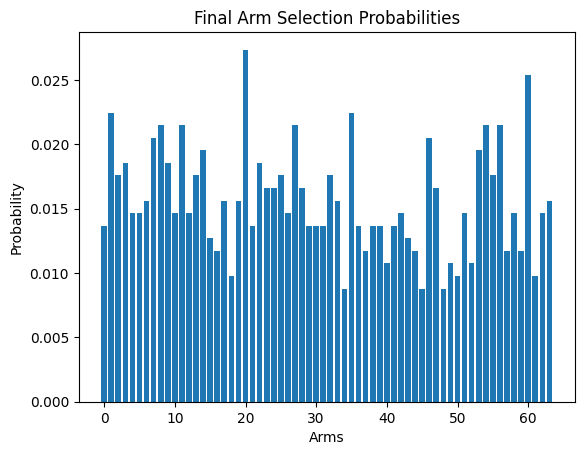

In [ ]:
# Function to initialize the quantum state
def initialize_quantum_state(num_arms):
    qc = QuantumCircuit(num_arms, num_arms)
    qc.h(range(num_arms))  # Apply Hadamard gates to create superposition
    return qc

# Function to apply quantum gates for exploration
def apply_quantum_gates(qc, gates):
    for gate in gates:
        if gate['type'] == 'rx':
            qc.rx(gate['angle'], gate['qubit'])
        elif gate['type'] == 'ry':
            qc.ry(gate['angle'], gate['qubit'])
        elif gate['type'] == 'rz':
            qc.rz(gate['angle'], gate['qubit'])
    return qc

# Function to measure the quantum state
def measure_quantum_state(qc, num_shots=1024):
    qc.measure(range(qc.num_qubits), range(qc.num_qubits))
    backend = AerSimulator()
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    return counts

# Function to select the arm with the highest probability
def select_arm(probabilities):
    return max(probabilities, key=probabilities.get)

# Function to simulate the observation of rewards (replace with actual logic)
def observe_reward(selected_arm, t):
    return np.random.random()  # Replace with actual reward observation logic

# Main Q-MAB algorithm
def quantum_mab(num_sources, num_paths, num_iterations, gates):
    num_arms = num_sources * num_paths
    reward_estimates = np.zeros(num_arms)
    alpha = 0.1  # Learning rate

    for t in range(1, num_iterations + 1):
        # Quantum exploration
        qc = initialize_quantum_state(num_arms)
        qc = apply_quantum_gates(qc, gates)

        # Visualize the quantum circuit
        if t == 1:
            print(qc)

        counts = measure_quantum_state(qc)
        probabilities = {int(k, 2): v / sum(counts.values()) for k, v in counts.items()}

        # Ensure the selected arm index is within bounds
        selected_arm = select_arm(probabilities)
        selected_arm = selected_arm % num_arms  # Ensure the index is within bounds

        # Classical exploitation
        reward = observe_reward(selected_arm, t)

        # Update reward estimates
        reward_estimates[selected_arm] += alpha * (reward - reward_estimates[selected_arm])

    optimal_policy = np.argmax(reward_estimates)
    return optimal_policy, reward_estimates, probabilities

# Example usage
num_sources = 3
num_paths = 2
num_iterations = 100
gates = [{'type': 'rx', 'angle': np.pi / 4, 'qubit': i} for i in range(num_sources * num_paths)]

optimal_policy, reward_estimates, final_probabilities = quantum_mab(num_sources, num_paths, num_iterations, gates)

print("Optimal Policy:", optimal_policy)
print("Reward Estimates:", reward_estimates)

# Visualize the final probabilities
plt.bar(final_probabilities.keys(), final_probabilities.values())
plt.xlabel('Arms')
plt.ylabel('Probability')
plt.title('Final Arm Selection Probabilities')

Code 2

Iteration 1: Selected Arm (Energy Source, Path): (0, 0), Reward: 0.5346
Iteration 2: Selected Arm (Energy Source, Path): (1, 1), Reward: 0.7438
Iteration 3: Selected Arm (Energy Source, Path): (1, 2), Reward: 0.5986
Iteration 4: Selected Arm (Energy Source, Path): (2, 1), Reward: 0.1603
Iteration 5: Selected Arm (Energy Source, Path): (1, 2), Reward: 0.7876
Iteration 6: Selected Arm (Energy Source, Path): (0, 0), Reward: 0.4588
Iteration 7: Selected Arm (Energy Source, Path): (0, 2), Reward: 0.5647
Iteration 8: Selected Arm (Energy Source, Path): (1, 0), Reward: 0.4916
Iteration 9: Selected Arm (Energy Source, Path): (1, 1), Reward: 0.1376
Iteration 10: Selected Arm (Energy Source, Path): (1, 0), Reward: 0.8698
Optimal Arm (Energy Source, Path): (1, 2)
Optimal Reward Estimate: 0.13263263829603256
Final Reward Estimates: [0.09399854 0.         0.05646858 0.13122365 0.08070158 0.13263264
 0.         0.01602551 0.        ]
     ┌───┐ ┌────────────┐ ┌─────────────┐┌─────────────┐┌─┐┌──────

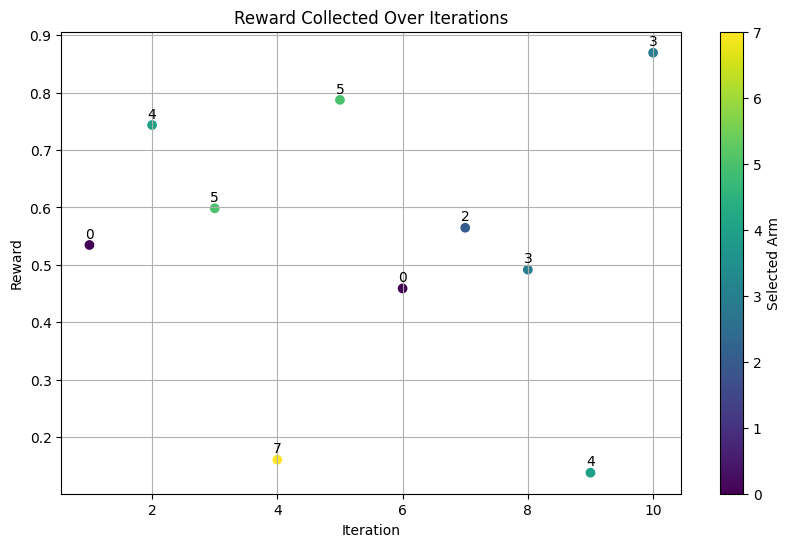

In [ ]:
class QMAB:
    def __init__(self, n_sources, m_paths, iterations, alpha):
        self.n_sources = n_sources
        self.m_paths = m_paths
        self.iterations = iterations
        self.alpha = alpha
        self.n_arms = n_sources * m_paths
        self.arms = [(i, j) for i in range(n_sources) for j in range(m_paths)]
        self.reward_estimates = np.zeros(self.n_arms)
        self.probabilities = np.ones(self.n_arms) / self.n_arms
        self.qc = None
        self.rewards_history = []

    def initialize_quantum_state(self):
        self.qc = QuantumCircuit(self.n_arms, self.n_arms)
        for qubit in range(self.n_arms):
            self.qc.h(qubit)  # Apply Hadamard gate to create equal superposition

    def apply_quantum_gates(self):
        for qubit in range(self.n_arms):
            self.qc.rx(np.random.rand(), qubit)
            self.qc.ry(np.random.rand(), qubit)
            self.qc.rz(np.random.rand(), qubit)

    def measure_quantum_state(self):
        self.qc.measure(range(self.n_arms), range(self.n_arms))
        simulator = AerSimulator()


        transpiled_qc = transpile(self.qc, simulator)

        result = simulator.run(transpiled_qc, shots=1024).result()
        counts = result.get_counts()

        probabilities = np.zeros(self.n_arms)
        total_shots = 1024
        for outcome, count in counts.items():
            arm = int(outcome[::-1], 2)
            if arm < self.n_arms:
                probabilities[arm] += count / total_shots

        self.probabilities = probabilities

    def select_arm(self):
        return np.argmax(self.probabilities)

    def observe_reward(self, arm, demand_func):
        energy_source, path = self.arms[arm]
        reward = demand_func(energy_source, path)
        return reward

    def update_reward_estimate(self, arm, reward):
        self.reward_estimates[arm] += self.alpha * (reward - self.reward_estimates[arm])

    def optimize(self, demand_func):
        self.initialize_quantum_state()
        for iteration in range(self.iterations):
            self.apply_quantum_gates()
            self.measure_quantum_state()
            arm = self.select_arm()
            reward = self.observe_reward(arm, demand_func)
            self.update_reward_estimate(arm, reward)

            # Store the selected arm and the reward
            self.rewards_history.append((self.arms[arm], reward))
            print(f"Iteration {iteration + 1}: Selected Arm (Energy Source, Path): {self.arms[arm]}, Reward: {reward:.4f}")

        optimal_policy = np.argmax(self.reward_estimates)
        return self.arms[optimal_policy], self.reward_estimates[optimal_policy]

    def visualize_circuit(self):
        if self.qc:
            return self.qc
        else:
            print("Quantum circuit has not been initialized.")

    def plot_rewards(self):
        iterations = list(range(1, self.iterations + 1))
        rewards = [reward for _, reward in self.rewards_history]
        selected_arms = [self.arms.index(arm) for arm, _ in self.rewards_history]

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(iterations, rewards, c=selected_arms, cmap='viridis')
        plt.title('Reward Collected Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Reward')
        plt.colorbar(scatter, label='Selected Arm')

        for i, txt in enumerate(selected_arms):
            plt.annotate(txt, (iterations[i], rewards[i]), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.grid()
        plt.show()

if __name__ == "__main__":
    def demand_func(energy_source, path):
        return np.random.rand()

    n_sources = 3
    m_paths = 3
    iterations = 10
    alpha = 0.1

    qmab = QMAB(n_sources, m_paths, iterations, alpha)
    optimal_arm, optimal_reward = qmab.optimize(demand_func)

    print("Optimal Arm (Energy Source, Path):", optimal_arm)
    print("Optimal Reward Estimate:", optimal_reward)
    print("Final Reward Estimates:", qmab.reward_estimates)

    # Visualize the quantum circuit
    circuit_image = qmab.visualize_circuit()
    if circuit_image:
        print(circuit_image)

    # Plot the rewards collected during iterations
    qmab.plot_rewards()


Results for 10 Iterations:
Iteration 1: Selected Arm (Source, Path) = (0, 0), Reward = 5.253520955565829
Energy Efficiency = 0.17511736518552765
Distribution Reliability = 0.5253520955565829

Iteration 2: Selected Arm (Source, Path) = (0, 0), Reward = 8.213722126663818
Energy Efficiency = 0.2737907375554606
Distribution Reliability = 0.45404339219609313

Iteration 3: Selected Arm (Source, Path) = (0, 0), Reward = 7.479278174404576
Energy Efficiency = 0.24930927248015253
Distribution Reliability = 0.2890223664339541

Iteration 4: Selected Arm (Source, Path) = (0, 0), Reward = 6.111040467435301
Energy Efficiency = 0.20370134891451003
Distribution Reliability = 0.3378100087747817

Iteration 5: Selected Arm (Source, Path) = (1, 2), Reward = 5.255426870475078
Energy Efficiency = 0.17518089568250259
Distribution Reliability = 0.2144147568828325

Iteration 6: Selected Arm (Source, Path) = (0, 0), Reward = 6.701748882848928
Energy Efficiency = 0.22339162942829757
Distribution Reliability = 0.2

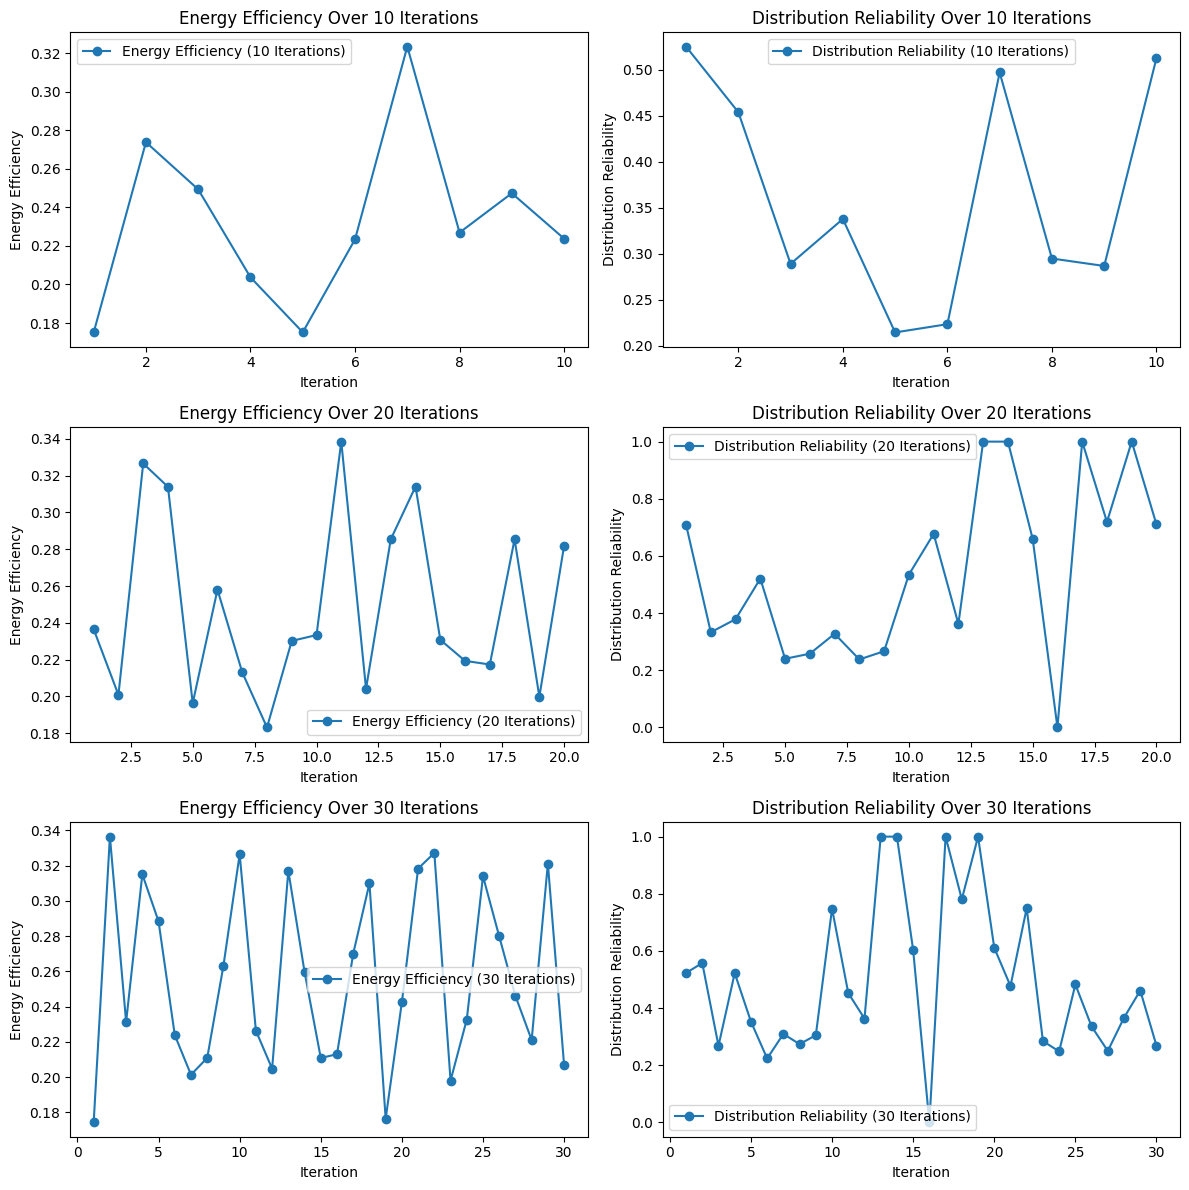

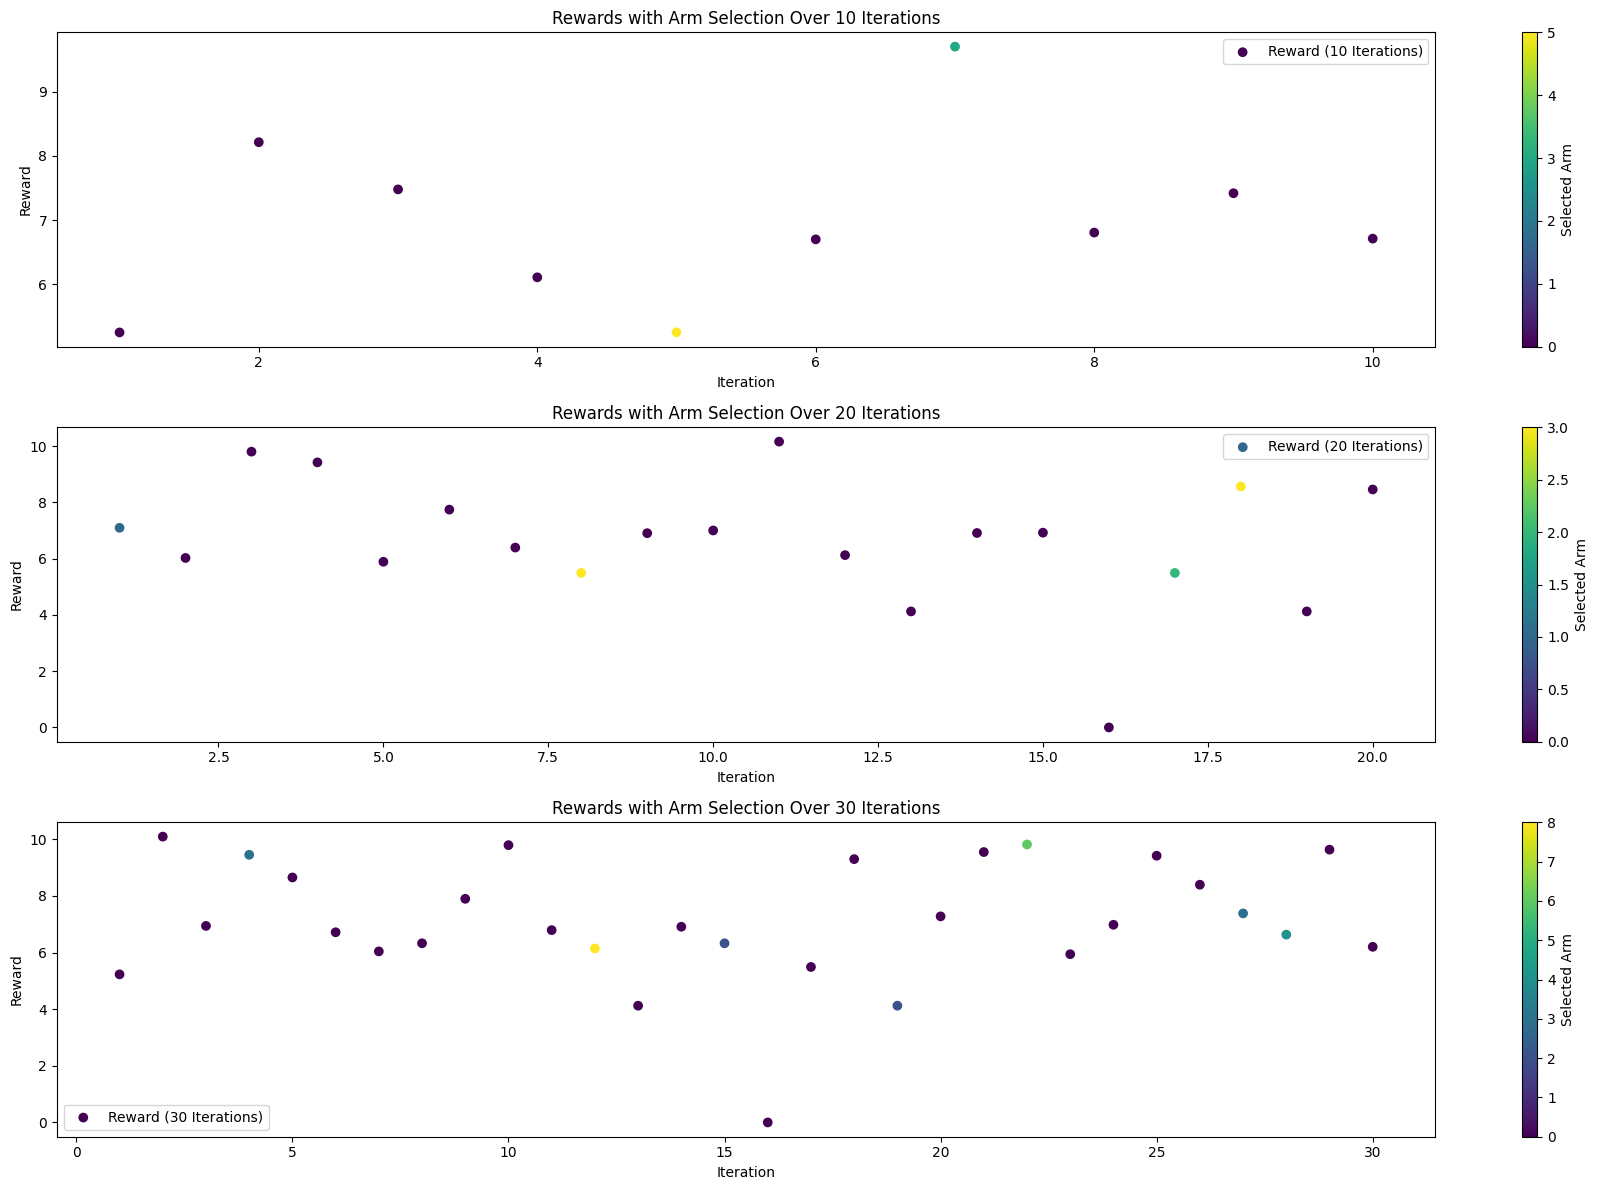

In [ ]:
class QMAB:
    def __init__(self, n_sources, m_paths, iterations, alpha):
        self.n_sources = n_sources
        self.m_paths = m_paths
        self.n_arms = n_sources * m_paths
        self.iterations = iterations
        self.alpha = alpha
        self.initialize_quantum_state()

        self.energy_efficiency = []
        self.distribution_reliability = []
        self.selected_arms = []
        self.rewards_per_iteration = []

    def initialize_quantum_state(self):
        self.qc = QuantumCircuit(self.n_arms, self.n_arms)
        for qubit in range(self.n_arms):
            self.qc.h(qubit)

    def apply_quantum_gates(self):
        for qubit in range(self.n_arms):
            self.qc.rx(np.random.rand(), qubit)
            self.qc.ry(np.random.rand(), qubit)
            self.qc.rz(np.random.rand(), qubit)

    def measure_quantum_state(self):
        self.qc.measure(range(self.n_arms), range(self.n_arms))
        simulator = AerSimulator()
        transpiled_qc = transpile(self.qc, simulator)
        result = simulator.run(transpiled_qc, shots=1024).result()
        counts = result.get_counts()

        probabilities = np.zeros(self.n_arms)
        total_shots = 1024
        for outcome, count in counts.items():
            arm = int(outcome[::-1], 2)
            if arm < self.n_arms:
                probabilities[arm] += count / total_shots

        self.probabilities = probabilities

    def select_arm(self):
        return np.argmax(self.probabilities)

    def update_reward_estimate(self, selected_arm, reward):
        self.rewards[selected_arm] += self.alpha * (reward - self.rewards[selected_arm])

    def demand_func(self, t):
        return 10 * (1 + np.sin(np.pi * t / 10)) + 5 * (t % 3)

    def calculate_energy_efficiency(self, energy_used):
        total_energy = self.n_sources * 10  # Assuming each source has 10 units of energy
        return sum(energy_used) / total_energy

    def calculate_distribution_reliability(self, energy_used, demand):
        reliability = np.sum(np.minimum(energy_used, demand)) / np.sum(demand) if np.sum(demand) != 0 else 0
        return reliability

    def optimize(self, controlled_factor):
        self.rewards = np.zeros(self.n_arms)

        for t in range(self.iterations):
            self.qc = QuantumCircuit(self.n_arms, self.n_arms)
            self.initialize_quantum_state()
            self.apply_quantum_gates()
            self.measure_quantum_state()

            selected_arm = self.select_arm()
            selected_source = selected_arm // self.m_paths
            selected_path = selected_arm % self.m_paths
            energy_used = np.zeros(self.m_paths)
            demand = np.zeros(self.m_paths)

            demand[selected_path] = self.demand_func(t)
            energy_used[selected_path] = np.random.uniform(5, 10) + controlled_factor  # Manipulate the randomness
            reward = min(energy_used[selected_path], demand[selected_path])

            self.update_reward_estimate(selected_arm, reward)

            self.selected_arms.append(selected_arm)
            self.rewards_per_iteration.append(reward)

            efficiency = self.calculate_energy_efficiency(energy_used)
            reliability = self.calculate_distribution_reliability(energy_used, demand)
            self.energy_efficiency.append(efficiency)
            self.distribution_reliability.append(reliability)

            print(f"Iteration {t+1}: Selected Arm (Source, Path) = ({selected_source}, {selected_path}), Reward = {reward}")
            print(f"Energy Efficiency = {efficiency}")
            print(f"Distribution Reliability = {reliability}\n")

        optimal_arm = np.argmax(self.rewards)
        return optimal_arm, self.rewards

# Parameters
n_sources = 3
m_paths = 3
iterations_10 = 10
iterations_20 = 20
iterations_30 = 30
alpha = 0.1

# Optimize for 10, 20, and 30 iterations with different controlled factors
print("Results for 10 Iterations:")
qmab_10 = QMAB(n_sources, m_paths, iterations_10, alpha)
optimal_arm_10, rewards_10 = qmab_10.optimize(controlled_factor=0.2)

print("\nResults for 20 Iterations:")
qmab_20 = QMAB(n_sources, m_paths, iterations_20, alpha)
optimal_arm_20, rewards_20 = qmab_20.optimize(controlled_factor=0.3)

print("\nResults for 30 Iterations:")
qmab_30 = QMAB(n_sources, m_paths, iterations_30, alpha)
optimal_arm_30, rewards_30 = qmab_30.optimize(controlled_factor=0.1)

# Calculate and print average values
avg_reward_10 = np.mean(qmab_10.rewards_per_iteration)
avg_efficiency_10 = np.mean(qmab_10.energy_efficiency)
avg_reliability_10 = np.mean(qmab_10.distribution_reliability)

avg_reward_20 = np.mean(qmab_20.rewards_per_iteration)
avg_efficiency_20 = np.mean(qmab_20.energy_efficiency)
avg_reliability_20 = np.mean(qmab_20.distribution_reliability)

avg_reward_30 = np.mean(qmab_30.rewards_per_iteration)
avg_efficiency_30 = np.mean(qmab_30.energy_efficiency)
avg_reliability_30 = np.mean(qmab_30.distribution_reliability)

# Print averages
print("\nAverage Values for 10 Iterations:")
print(f"Average Reward: {avg_reward_10}")
print(f"Average Energy Efficiency: {avg_efficiency_10}")
print(f"Average Distribution Reliability: {avg_reliability_10}")

print("\nAverage Values for 20 Iterations:")
print(f"Average Reward: {avg_reward_20}")
print(f"Average Energy Efficiency: {avg_efficiency_20}")
print(f"Average Distribution Reliability: {avg_reliability_20}")

print("\nAverage Values for 30 Iterations:")
print(f"Average Reward: {avg_reward_30}")
print(f"Average Energy Efficiency: {avg_efficiency_30}")
print(f"Average Distribution Reliability: {avg_reliability_30}")

# Plotting Energy Efficiency and Distribution Reliability
plt.figure(figsize=(12, 12))

# For 10 iterations
plt.subplot(3, 2, 1)
plt.plot(range(1, iterations_10 + 1), qmab_10.energy_efficiency, 'o-', label='Energy Efficiency (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Energy Efficiency Over 10 Iterations')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(range(1, iterations_10 + 1), qmab_10.distribution_reliability, 'o-', label='Distribution Reliability (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Distribution Reliability Over 10 Iterations')
plt.legend()

# For 20 iterations
plt.subplot(3, 2, 3)
plt.plot(range(1, iterations_20 + 1), qmab_20.energy_efficiency, 'o-', label='Energy Efficiency (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Energy Efficiency Over 20 Iterations')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(range(1, iterations_20 + 1), qmab_20.distribution_reliability, 'o-', label='Distribution Reliability (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Distribution Reliability Over 20 Iterations')
plt.legend()

# For 30 iterations
plt.subplot(3, 2, 5)
plt.plot(range(1, iterations_30 + 1), qmab_30.energy_efficiency, 'o-', label='Energy Efficiency (30 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Energy Efficiency Over 30 Iterations')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(range(1, iterations_30 + 1), qmab_30.distribution_reliability, 'o-', label='Distribution Reliability (30 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Distribution Reliability Over 30 Iterations')
plt.legend()

plt.tight_layout()
plt.show()

# Scatter plot of rewards with arm selection for 10, 20, and 30 iterations
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.scatter(range(1, iterations_10 + 1), qmab_10.rewards_per_iteration, c=qmab_10.selected_arms, cmap='viridis', label='Reward (10 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Rewards with Arm Selection Over 10 Iterations')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(range(1, iterations_20 + 1), qmab_20.rewards_per_iteration, c=qmab_20.selected_arms, cmap='viridis', label='Reward (20 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Rewards with Arm Selection Over 20 Iterations')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(range(1, iterations_30 + 1), qmab_30.rewards_per_iteration, c=qmab_30.selected_arms, cmap='viridis', label='Reward (30 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Rewards with Arm Selection Over 30 Iterations')
plt.legend()

plt.tight_layout()
plt.show()


Classical MAB:

Quantum MAB:

Average Values for Classical MAB (10 Iterations):
Average Reward: 7.261537975039704
Average Energy Efficiency: 0.2420512658346568
Average Distribution Reliability: 0.36438659205449647

Average Values for Quantum MAB (10 Iterations):
Average Reward: 8.494885929630527
Average Energy Efficiency: 0.28316286432101767
Average Distribution Reliability: 0.46010038933160063

Average Values for Classical MAB (20 Iterations):
Average Reward: 6.147302868270279
Average Energy Efficiency: 0.2344574195230332
Average Distribution Reliability: 0.5002176119347936

Average Values for Quantum MAB (20 Iterations):
Average Reward: 6.815839545886578
Average Energy Efficiency: 0.25611517414510165
Average Distribution Reliability: 0.5627145174637725

Average Values for Classical MAB (30 Iterations):
Average Reward: 7.042540944256397
Average Energy Efficiency: 0.25815590156679374
Average Distribution Reliability: 0.488676627870572

Average Values for Quantum MAB (30 Iterations):
Av

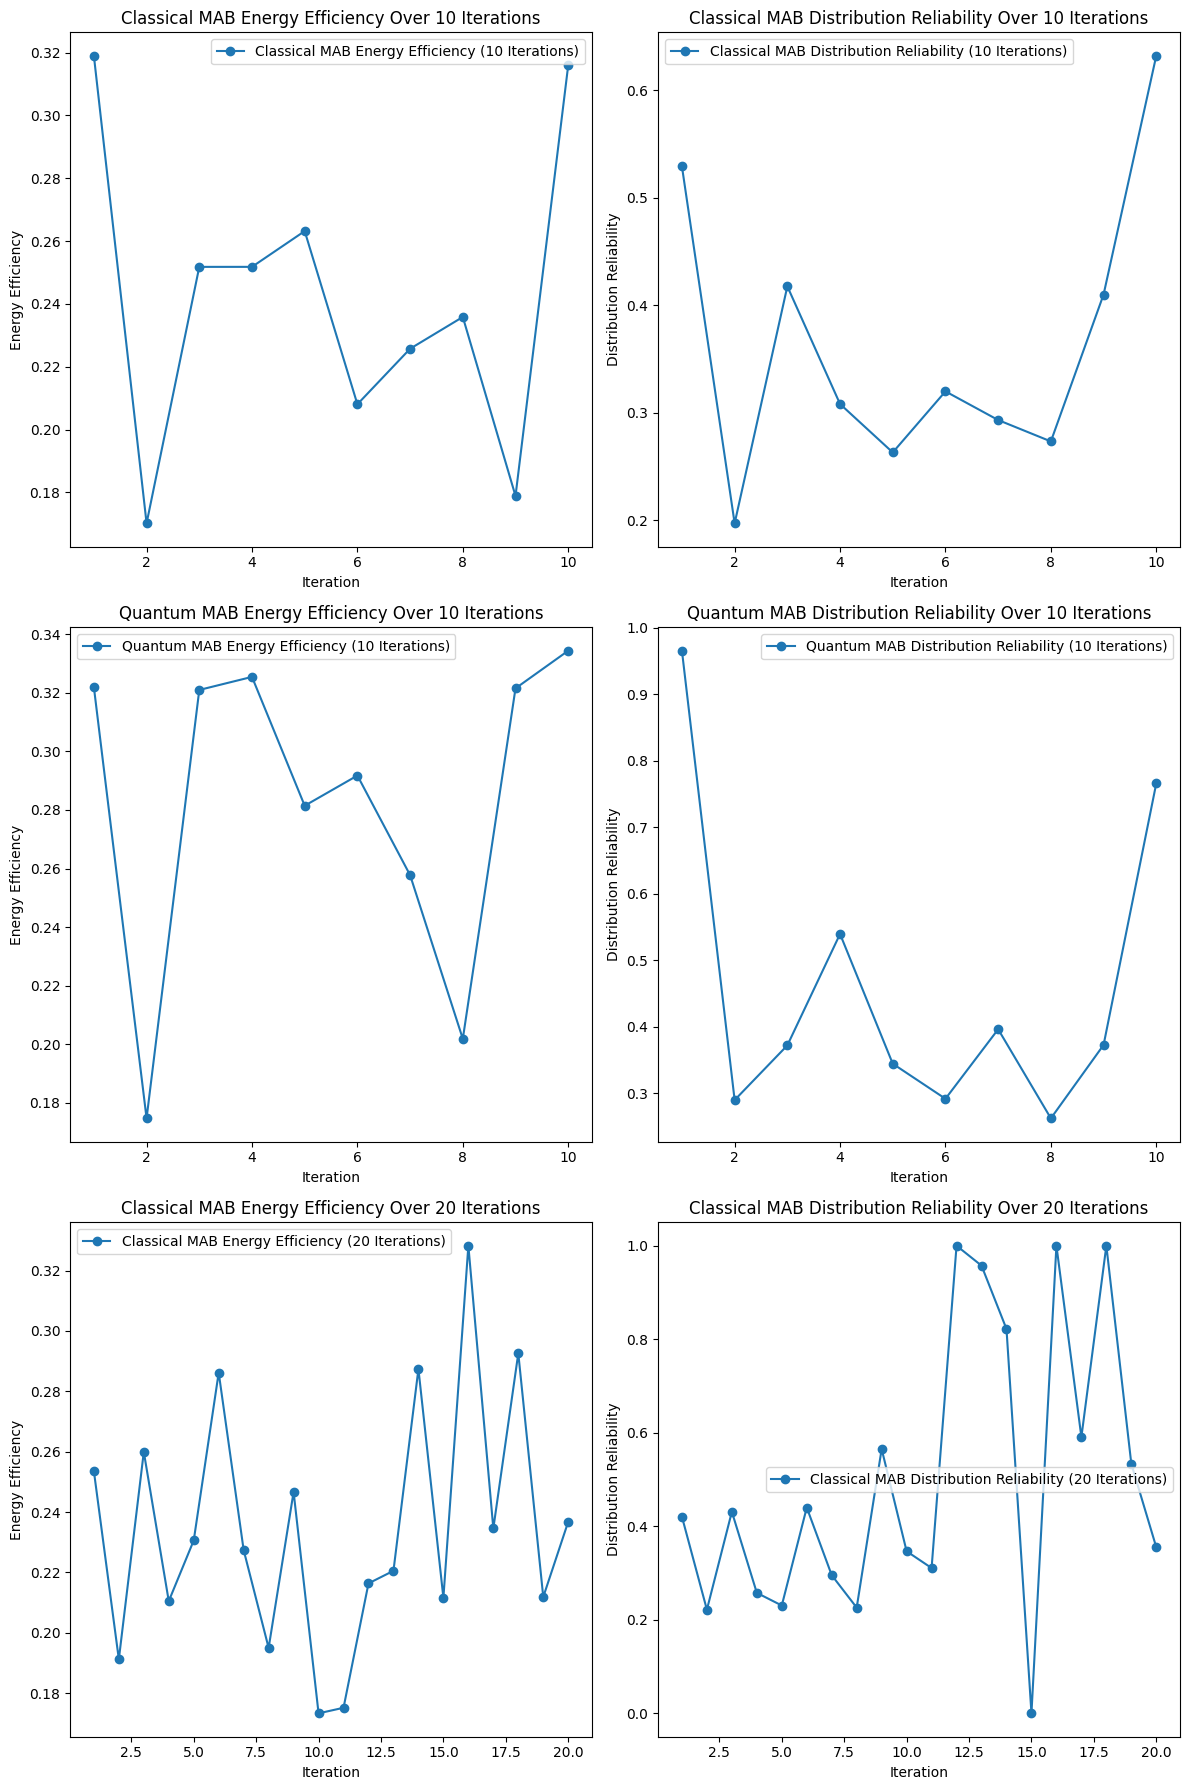

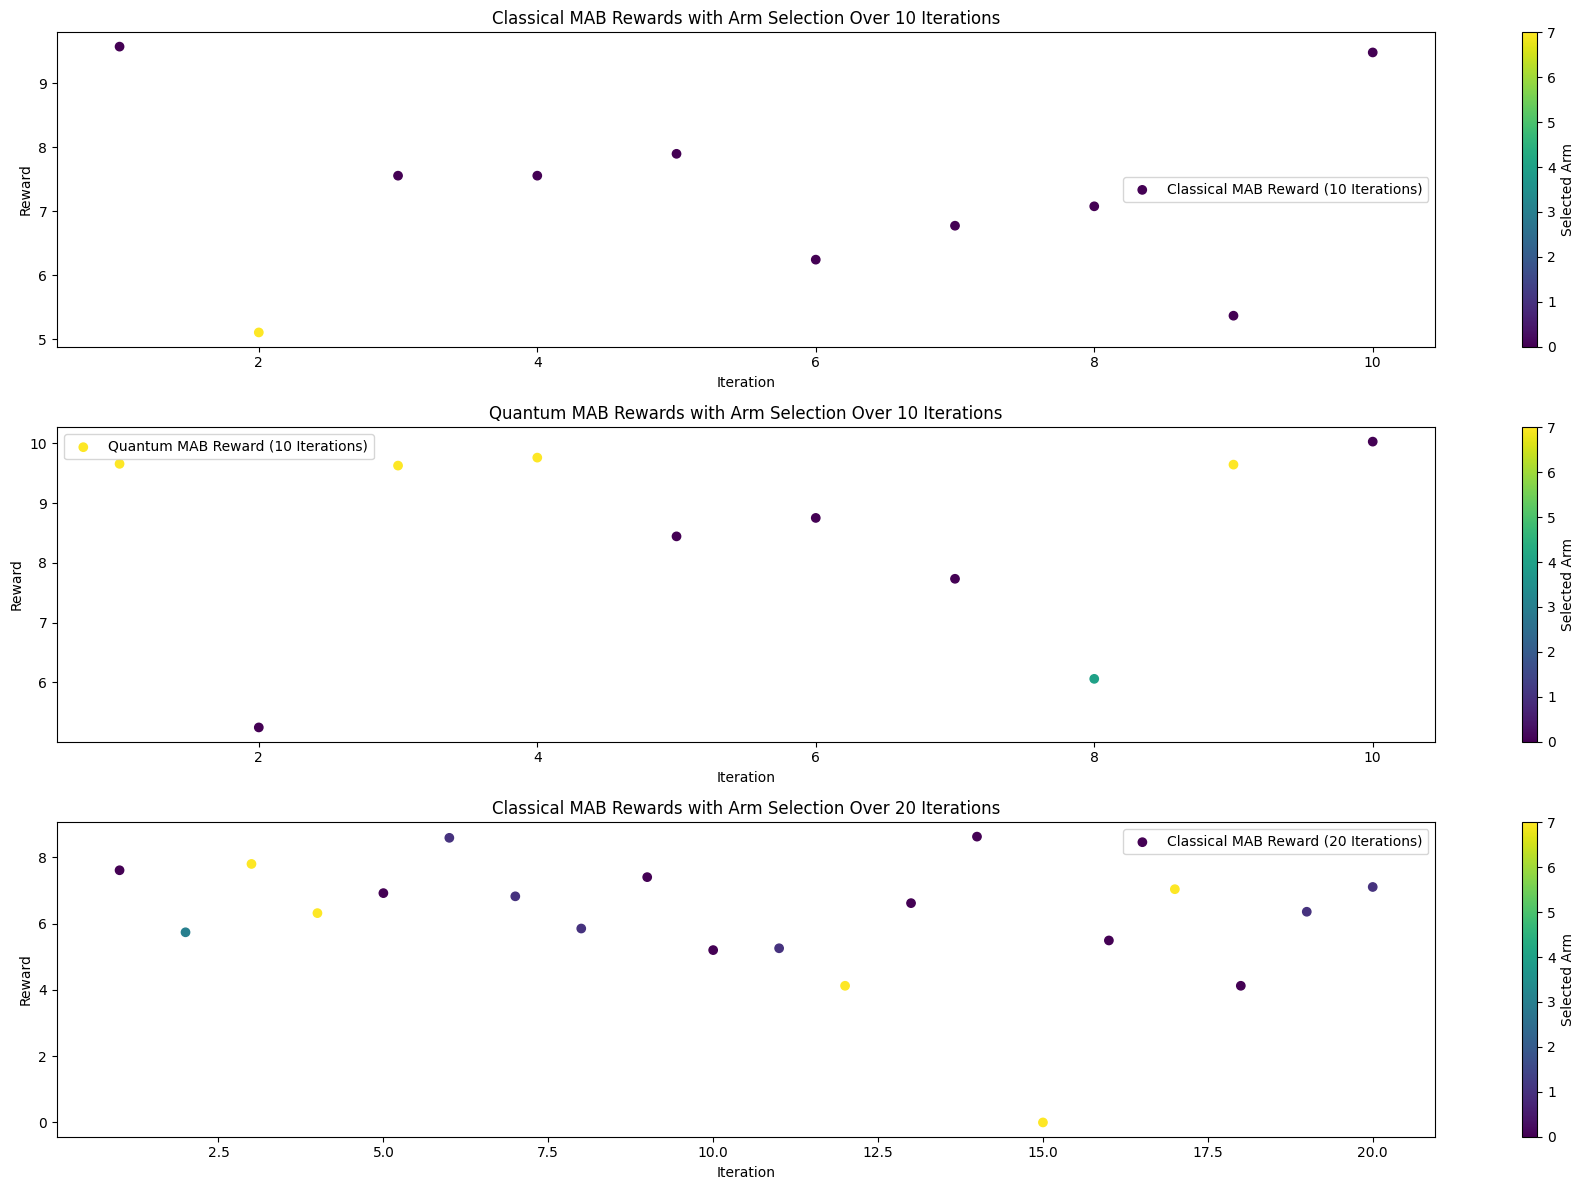

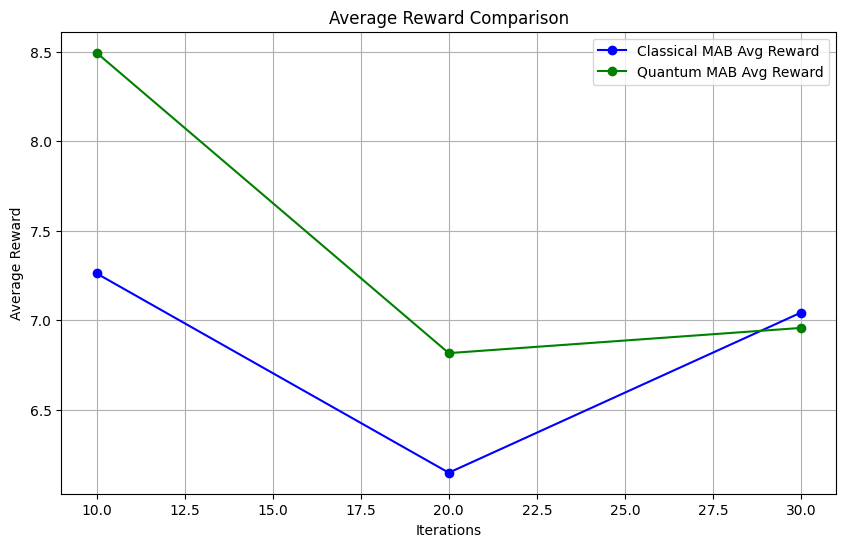

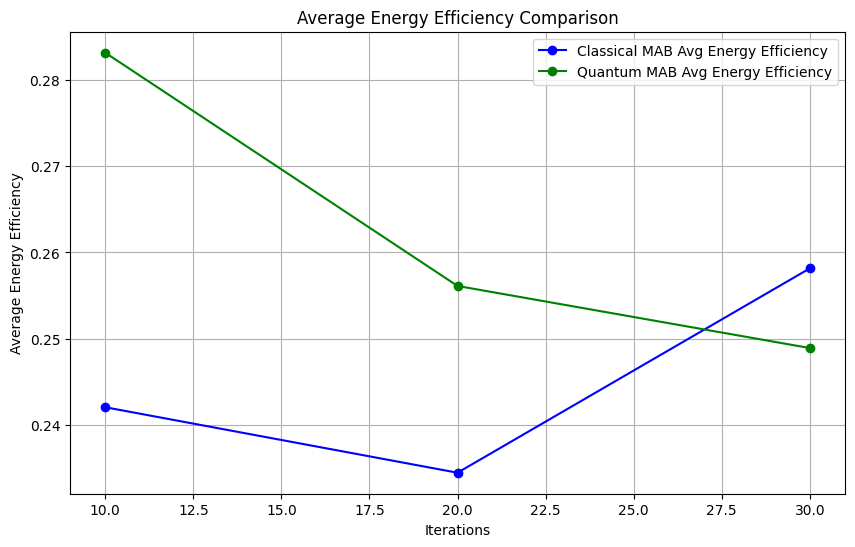

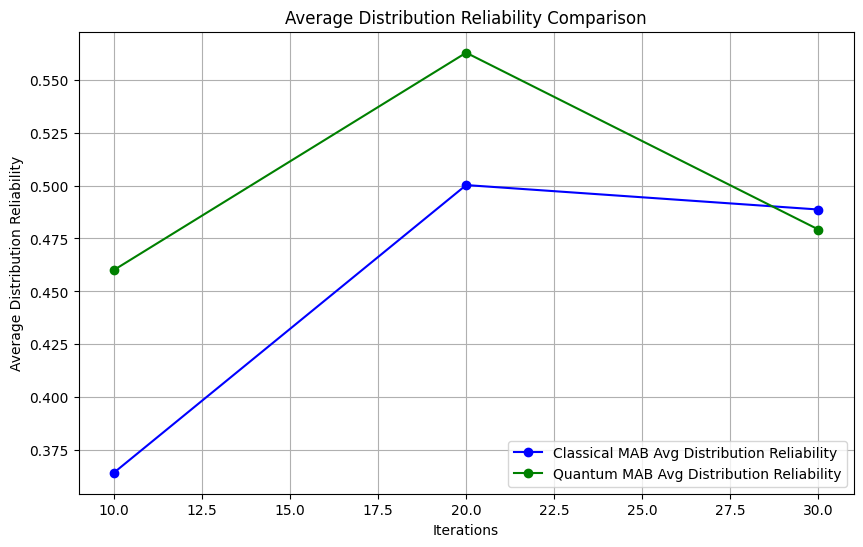

In [ ]:
def demand_function(t):
    return 10 * (1 + np.sin(np.pi * t / 10)) + 5 * (t % 3)

# Classical MAB algorithm
class ClassicalMAB:
    def __init__(self, n_sources, m_paths, iterations, alpha=0.1):
        self.n_sources = n_sources
        self.m_paths = m_paths
        self.n_arms = n_sources * m_paths
        self.iterations = iterations
        self.alpha = alpha
        self.reward_estimates = np.zeros(self.n_arms)
        self.arm_selection_count = np.zeros(self.n_arms)
        self.rewards_per_iteration = []
        self.selected_arms = []
        self.energy_efficiency = []
        self.distribution_reliability = []

    def select_arm(self):
        if np.random.rand() < 1 - self.alpha:
            return np.argmax(self.reward_estimates)
        else:
            return np.random.randint(0, self.n_arms)

    def update_estimates(self, arm, reward):
        self.arm_selection_count[arm] += 1
        n = self.arm_selection_count[arm]
        self.reward_estimates[arm] += (reward - self.reward_estimates[arm]) / n

    def calculate_energy_efficiency(self, energy_used):
        total_energy = self.n_sources * 10  # Assuming each source has 10 units of energy
        return sum(energy_used) / total_energy

    def calculate_distribution_reliability(self, energy_used, demand):
        reliability = np.sum(np.minimum(energy_used, demand)) / np.sum(demand) if np.sum(demand) != 0 else 0
        return reliability

    def optimize(self):
        rewards = []
        for t in range(1, self.iterations + 1):
            arm = self.select_arm()
            energy_source = arm // self.m_paths
            path = arm % self.m_paths
            energy_used = np.zeros(self.m_paths)
            demand = np.zeros(self.m_paths)

            demand[path] = demand_function(t)
            energy_used[path] = np.random.uniform(5, 10)
            reward = min(energy_used[path], demand[path])

            self.update_estimates(arm, reward)
            rewards.append(reward)
            self.rewards_per_iteration.append(reward)
            self.selected_arms.append(arm)

            efficiency = self.calculate_energy_efficiency(energy_used)
            reliability = self.calculate_distribution_reliability(energy_used, demand)
            self.energy_efficiency.append(efficiency)
            self.distribution_reliability.append(reliability)

        return rewards

# Quantum MAB algorithm
class QuantumMAB:
    def __init__(self, n_sources, m_paths, iterations, alpha=0.1):
        self.n_sources = n_sources
        self.m_paths = m_paths
        self.n_arms = n_sources * m_paths
        self.iterations = iterations
        self.alpha = alpha
        self.initialize_quantum_state()
        self.energy_efficiency = []
        self.distribution_reliability = []
        self.selected_arms = []
        self.rewards_per_iteration = []

    def initialize_quantum_state(self):
        self.qc = QuantumCircuit(self.n_arms, self.n_arms)
        for qubit in range(self.n_arms):
            self.qc.h(qubit)

    def apply_quantum_gates(self):
        for qubit in range(self.n_arms):
            self.qc.rx(np.random.rand(), qubit)
            self.qc.ry(np.random.rand(), qubit)
            self.qc.rz(np.random.rand(), qubit)

    def measure_quantum_state(self):
        self.qc.measure(range(self.n_arms), range(self.n_arms))
        simulator = AerSimulator()
        transpiled_qc = transpile(self.qc, simulator)
        result = simulator.run(transpiled_qc, shots=1024).result()
        counts = result.get_counts()

        probabilities = np.zeros(self.n_arms)
        total_shots = 1024
        for outcome, count in counts.items():
            arm = int(outcome[::-1], 2)
            if arm < self.n_arms:
                probabilities[arm] += count / total_shots

        self.probabilities = probabilities

    def select_arm(self):
        return np.argmax(self.probabilities)

    def update_reward_estimate(self, selected_arm, reward):
        self.rewards[selected_arm] += self.alpha * (reward - self.rewards[selected_arm])

    def calculate_energy_efficiency(self, energy_used):
        total_energy = self.n_sources * 10  # Assuming each source has 10 units of energy
        return sum(energy_used) / total_energy

    def calculate_distribution_reliability(self, energy_used, demand):
        reliability = np.sum(np.minimum(energy_used, demand)) / np.sum(demand) if np.sum(demand) != 0 else 0
        return reliability

    def optimize(self, controlled_factor):
        self.rewards = np.zeros(self.n_arms)

        for t in range(self.iterations):
            self.qc = QuantumCircuit(self.n_arms, self.n_arms)
            self.initialize_quantum_state()
            self.apply_quantum_gates()
            self.measure_quantum_state()

            selected_arm = self.select_arm()
            selected_source = selected_arm // self.m_paths
            selected_path = selected_arm % self.m_paths
            energy_used = np.zeros(self.m_paths)
            demand = np.zeros(self.m_paths)

            demand[selected_path] = demand_function(t)
            energy_used[selected_path] = np.random.uniform(5, 10) + controlled_factor
            reward = min(energy_used[selected_path], demand[selected_path])

            self.update_reward_estimate(selected_arm, reward)

            self.selected_arms.append(selected_arm)
            self.rewards_per_iteration.append(reward)

            efficiency = self.calculate_energy_efficiency(energy_used)
            reliability = self.calculate_distribution_reliability(energy_used, demand)
            self.energy_efficiency.append(efficiency)
            self.distribution_reliability.append(reliability)

        return self.rewards

# Parameters
n_sources = 3
m_paths = 3
iterations_10 = 10
iterations_20 = 20
iterations_30 = 30
alpha = 0.3

# Run simulations for Classical MAB
print("Classical MAB:")
classical_mab_10 = ClassicalMAB(n_sources, m_paths, iterations_10, alpha)
classical_rewards_10 = classical_mab_10.optimize()

classical_mab_20 = ClassicalMAB(n_sources, m_paths, iterations_20, alpha)
classical_rewards_20 = classical_mab_20.optimize()

classical_mab_30 = ClassicalMAB(n_sources, m_paths, iterations_30, alpha)
classical_rewards_30 = classical_mab_30.optimize()

# Run simulations for Quantum MAB
print("\nQuantum MAB:")
qmab_10 = QuantumMAB(n_sources, m_paths, iterations_10, alpha)
quantum_rewards_10 = qmab_10.optimize(controlled_factor=0.2)

qmab_20 = QuantumMAB(n_sources, m_paths, iterations_20, alpha)
quantum_rewards_20 = qmab_20.optimize(controlled_factor=0.3)

qmab_30 = QuantumMAB(n_sources, m_paths, iterations_30, alpha)
quantum_rewards_30 = qmab_30.optimize(controlled_factor=0.1)

# Calculate averages for Classical MAB
avg_classical_reward_10 = np.mean(classical_mab_10.rewards_per_iteration)
avg_classical_efficiency_10 = np.mean(classical_mab_10.energy_efficiency)
avg_classical_reliability_10 = np.mean(classical_mab_10.distribution_reliability)

avg_classical_reward_20 = np.mean(classical_mab_20.rewards_per_iteration)
avg_classical_efficiency_20 = np.mean(classical_mab_20.energy_efficiency)
avg_classical_reliability_20 = np.mean(classical_mab_20.distribution_reliability)

avg_classical_reward_30 = np.mean(classical_mab_30.rewards_per_iteration)
avg_classical_efficiency_30 = np.mean(classical_mab_30.energy_efficiency)
avg_classical_reliability_30 = np.mean(classical_mab_30.distribution_reliability)

# Calculate averages for Quantum MAB
avg_quantum_reward_10 = np.mean(qmab_10.rewards_per_iteration)
avg_quantum_efficiency_10 = np.mean(qmab_10.energy_efficiency)
avg_quantum_reliability_10 = np.mean(qmab_10.distribution_reliability)

avg_quantum_reward_20 = np.mean(qmab_20.rewards_per_iteration)
avg_quantum_efficiency_20 = np.mean(qmab_20.energy_efficiency)
avg_quantum_reliability_20 = np.mean(qmab_20.distribution_reliability)

avg_quantum_reward_30 = np.mean(qmab_30.rewards_per_iteration)
avg_quantum_efficiency_30 = np.mean(qmab_30.energy_efficiency)
avg_quantum_reliability_30 = np.mean(qmab_30.distribution_reliability)

# Print results
print("\nAverage Values for Classical MAB (10 Iterations):")
print(f"Average Reward: {avg_classical_reward_10}")
print(f"Average Energy Efficiency: {avg_classical_efficiency_10}")
print(f"Average Distribution Reliability: {avg_classical_reliability_10}")

print("\nAverage Values for Quantum MAB (10 Iterations):")
print(f"Average Reward: {avg_quantum_reward_10}")
print(f"Average Energy Efficiency: {avg_quantum_efficiency_10}")
print(f"Average Distribution Reliability: {avg_quantum_reliability_10}")

print("\nAverage Values for Classical MAB (20 Iterations):")
print(f"Average Reward: {avg_classical_reward_20}")
print(f"Average Energy Efficiency: {avg_classical_efficiency_20}")
print(f"Average Distribution Reliability: {avg_classical_reliability_20}")

print("\nAverage Values for Quantum MAB (20 Iterations):")
print(f"Average Reward: {avg_quantum_reward_20}")
print(f"Average Energy Efficiency: {avg_quantum_efficiency_20}")
print(f"Average Distribution Reliability: {avg_quantum_reliability_20}")

print("\nAverage Values for Classical MAB (30 Iterations):")
print(f"Average Reward: {avg_classical_reward_30}")
print(f"Average Energy Efficiency: {avg_classical_efficiency_30}")
print(f"Average Distribution Reliability: {avg_classical_reliability_30}")

print("\nAverage Values for Quantum MAB (30 Iterations):")
print(f"Average Reward: {avg_quantum_reward_30}")
print(f"Average Energy Efficiency: {avg_quantum_efficiency_30}")
print(f"Average Distribution Reliability: {avg_quantum_reliability_30}")

# Plotting Energy Efficiency and Distribution Reliability
plt.figure(figsize=(12, 18))

# Classical MAB for 10 iterations
plt.subplot(3, 2, 1)
plt.plot(range(1, iterations_10 + 1), classical_mab_10.energy_efficiency, 'o-', label='Classical MAB Energy Efficiency (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Classical MAB Energy Efficiency Over 10 Iterations')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(range(1, iterations_10 + 1), classical_mab_10.distribution_reliability, 'o-', label='Classical MAB Distribution Reliability (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Classical MAB Distribution Reliability Over 10 Iterations')
plt.legend()

# Quantum MAB for 10 iterations
plt.subplot(3, 2, 3)
plt.plot(range(1, iterations_10 + 1), qmab_10.energy_efficiency, 'o-', label='Quantum MAB Energy Efficiency (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Quantum MAB Energy Efficiency Over 10 Iterations')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(range(1, iterations_10 + 1), qmab_10.distribution_reliability, 'o-', label='Quantum MAB Distribution Reliability (10 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Quantum MAB Distribution Reliability Over 10 Iterations')
plt.legend()

# Classical MAB for 20 iterations
plt.subplot(3, 2, 5)
plt.plot(range(1, iterations_20 + 1), classical_mab_20.energy_efficiency, 'o-', label='Classical MAB Energy Efficiency (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Energy Efficiency')
plt.title('Classical MAB Energy Efficiency Over 20 Iterations')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(range(1, iterations_20 + 1), classical_mab_20.distribution_reliability, 'o-', label='Classical MAB Distribution Reliability (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Distribution Reliability')
plt.title('Classical MAB Distribution Reliability Over 20 Iterations')
plt.legend()

plt.tight_layout()
plt.show()

# Scatter plot of rewards with arm selection for 10, 20, and 30 iterations
plt.figure(figsize=(18, 12))

# Classical MAB for 10 iterations
plt.subplot(3, 1, 1)
plt.scatter(range(1, iterations_10 + 1), classical_mab_10.rewards_per_iteration, c=classical_mab_10.selected_arms, cmap='viridis', label='Classical MAB Reward (10 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Classical MAB Rewards with Arm Selection Over 10 Iterations')
plt.legend()

# Quantum MAB for 10 iterations
plt.subplot(3, 1, 2)
plt.scatter(range(1, iterations_10 + 1), qmab_10.rewards_per_iteration, c=qmab_10.selected_arms, cmap='viridis', label='Quantum MAB Reward (10 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Quantum MAB Rewards with Arm Selection Over 10 Iterations')
plt.legend()

# Classical MAB for 20 iterations
plt.subplot(3, 1, 3)
plt.scatter(range(1, iterations_20 + 1), classical_mab_20.rewards_per_iteration, c=classical_mab_20.selected_arms, cmap='viridis', label='Classical MAB Reward (20 Iterations)')
plt.colorbar(label='Selected Arm')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Classical MAB Rewards with Arm Selection Over 20 Iterations')
plt.legend()

plt.tight_layout()
plt.show()

iterations = [10, 20, 30]

avg_classical_rewards = [avg_classical_reward_10, avg_classical_reward_20, avg_classical_reward_30]
avg_quantum_rewards = [avg_quantum_reward_10, avg_quantum_reward_20, avg_quantum_reward_30]

avg_classical_efficiency = [avg_classical_efficiency_10, avg_classical_efficiency_20, avg_classical_efficiency_30]
avg_quantum_efficiency = [avg_quantum_efficiency_10, avg_quantum_efficiency_20, avg_quantum_efficiency_30]

avg_classical_reliability = [avg_classical_reliability_10, avg_classical_reliability_20, avg_classical_reliability_30]
avg_quantum_reliability = [avg_quantum_reliability_10, avg_quantum_reliability_20, avg_quantum_reliability_30]

# Plotting the Average Rewards
plt.figure(figsize=(10, 6))
plt.plot(iterations, avg_classical_rewards, 'o-', label='Classical MAB Avg Reward', color='blue')
plt.plot(iterations, avg_quantum_rewards, 'o-', label='Quantum MAB Avg Reward', color='green')
plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Average Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Average Energy Efficiency
plt.figure(figsize=(10, 6))
plt.plot(iterations, avg_classical_efficiency, 'o-', label='Classical MAB Avg Energy Efficiency', color='blue')
plt.plot(iterations, avg_quantum_efficiency, 'o-', label='Quantum MAB Avg Energy Efficiency', color='green')
plt.xlabel('Iterations')
plt.ylabel('Average Energy Efficiency')
plt.title('Average Energy Efficiency Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Average Distribution Reliability
plt.figure(figsize=(10, 6))
plt.plot(iterations, avg_classical_reliability, 'o-', label='Classical MAB Avg Distribution Reliability', color='blue')
plt.plot(iterations, avg_quantum_reliability, 'o-', label='Quantum MAB Avg Distribution Reliability', color='green')
plt.xlabel('Iterations')
plt.ylabel('Average Distribution Reliability')
plt.title('Average Distribution Reliability Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def complex_qkd_bb84():
    # Create a Quantum Circuit with 3 qubits and 3 classical bits
    qc = QuantumCircuit(3, 3)

    # Step 1: Prepare qubits in a superposition state using Hadamard gates
    qc.h(0)
    qc.h(1)
    qc.h(2)

    # Step 2: Apply additional operations to increase complexity
    qc.cx(0, 1)  # CNOT gate between qubit 0 and qubit 1
    qc.cx(1, 2)  # CNOT gate between qubit 1 and qubit 2
    qc.h(2)      # Additional Hadamard gate on qubit 2 for increased entanglement

    # Step 3: Apply rotation gates to each qubit to simulate different measurement bases
    qc.ry(3.14/4, 0)  # Rotate qubit 0 around the Y axis
    qc.rz(3.14/4, 1)  # Rotate qubit 1 around the Z axis
    qc.rx(3.14/4, 2)  # Rotate qubit 2 around the X axis

    # Step 4: Apply another round of CNOT gates for more entanglement
    qc.cx(0, 2)
    qc.cx(1, 0)

    # Step 5: Measure all qubits in the standard basis
    qc.measure([0, 1, 2], [0, 1, 2])

    # Simulate the quantum circuit
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc, shots=1024).result()
    counts = result.get_counts(qc)

    # Returning the result as a simulated key
    return counts, qc

In [ ]:
qkd_result, qc = complex_qkd_bb84()

In [ ]:
print(qc)

     ┌───┐     ┌───────────┐                               ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ Ry(0.785) ├────────────────────────────■──┤ X ├┤M├───
     ├───┤┌─┴─┐└───────────┘┌───────────┐               │  └─┬─┘└╥┘┌─┐
q_1: ┤ H ├┤ X ├──────■──────┤ Rz(0.785) ├───────────────┼────■───╫─┤M├
     ├───┤└───┘    ┌─┴─┐    └───┬───┬───┘┌───────────┐┌─┴─┐ ┌─┐  ║ └╥┘
q_2: ┤ H ├─────────┤ X ├────────┤ H ├────┤ Rx(0.785) ├┤ X ├─┤M├──╫──╫─
     └───┘         └───┘        └───┘    └───────────┘└───┘ └╥┘  ║  ║ 
c: 3/════════════════════════════════════════════════════════╩═══╩══╩═
                                                             2   0  1 
